In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io 
import random
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import seaborn as sn
import pandas as pd
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

## Dataset Processing 
### Read in the original dataset 

In [2]:
train_dl_origin = torch.load('train_dl.pt')
valid_dl_origin = torch.load('valid_dl.pt')

train_CSI = train_dl_origin.dataset[:][0]
train_label = train_dl_origin.dataset[:][1][:,2].type(torch.LongTensor)

valid_CSI = valid_dl_origin.dataset[:][0]
valid_label = valid_dl_origin.dataset[:][1][:,2].type(torch.LongTensor)

### CSI Processing Method 1: Take Modulus of complex matrices

In [3]:
train_CSI_modulus = torch.abs(train_CSI)
valid_CSI_modulus = torch.abs(valid_CSI)

### Show the size of the training and valiation dataset

In [4]:
print(train_CSI_modulus.shape)
print(valid_CSI_modulus.shape)

torch.Size([15000, 1, 4, 1632])
torch.Size([5000, 1, 4, 1632])


### Show a pilot signal in frequence domain

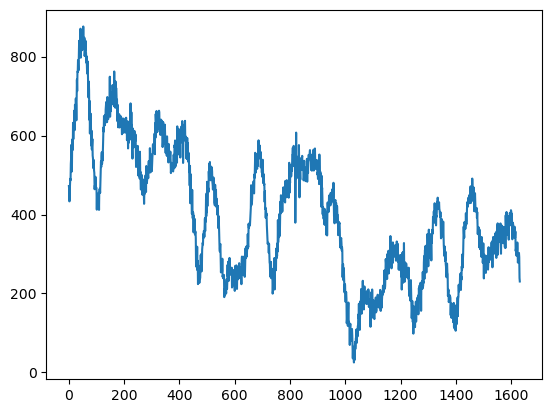

In [5]:
plt.plot(train_CSI_modulus[10,0,0,:])

In [6]:
train_CSI = train_dl_origin.dataset[:][0]
train_label = train_dl_origin.dataset[:][1]
valid_CSI = valid_dl_origin.dataset[:][0]
valid_label = valid_dl_origin.dataset[:][1]

In [7]:
def print_dataset_stats(CSI, labels, dataset_name):
    print(f"{dataset_name} Dataset Statistics:")
    print(f"Number of samples: {CSI.shape[0]}")
    print(f"CSI matrix shape: {CSI.shape[1:]}")
    print(f"Label shape: {labels.shape[1:]}")
    print(f"LoS Samples: {labels[:, 2].eq(0).sum().item()}")
    print(f"NLoS Samples: {labels[:, 2].eq(1).sum().item()}\n")

print_dataset_stats(train_CSI, train_label, "Training")
print_dataset_stats(valid_CSI, valid_label, "Validation")

def plot_los_distribution(labels, dataset_name):
    sns.countplot(labels[:, 2].numpy())
    plt.title(f'{dataset_name} LoS/NLoS Distribution')
    plt.xticks([0, 1], ['LoS', 'NLoS'])
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.show()


Training Dataset Statistics:
Number of samples: 15000
CSI matrix shape: torch.Size([1, 4, 1632])
Label shape: torch.Size([3])
LoS Samples: 12340
NLoS Samples: 2660

Validation Dataset Statistics:
Number of samples: 5000
CSI matrix shape: torch.Size([1, 4, 1632])
Label shape: torch.Size([3])
LoS Samples: 4064
NLoS Samples: 936



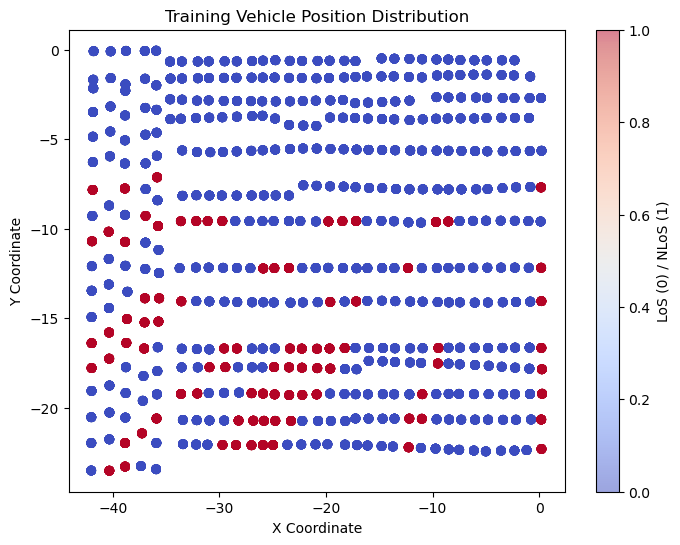

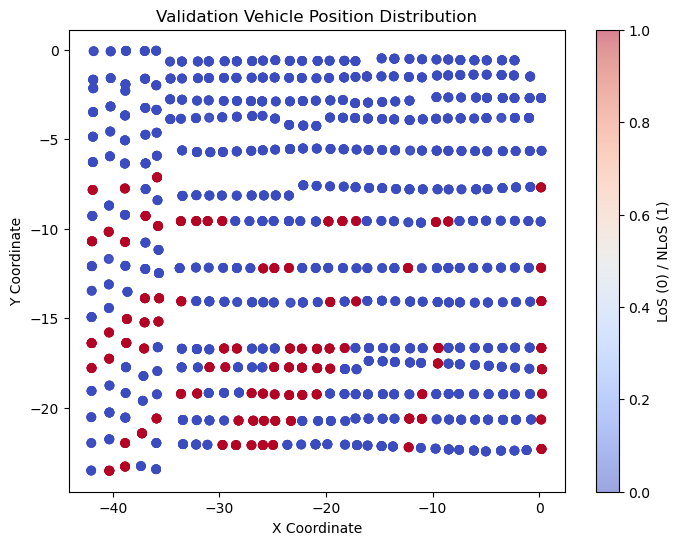

In [21]:
import seaborn as sns



def plot_coordinate_distribution(labels, dataset_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(labels[:, 0].numpy(), labels[:, 1].numpy(), c=labels[:, 2].numpy(), cmap='coolwarm', alpha=0.5)
    plt.title(f'{dataset_name} Vehicle Position Distribution')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.colorbar(label='LoS (0) / NLoS (1)')
    plt.show()

plot_coordinate_distribution(train_label, "Training")
plot_coordinate_distribution(valid_label, "Validation")

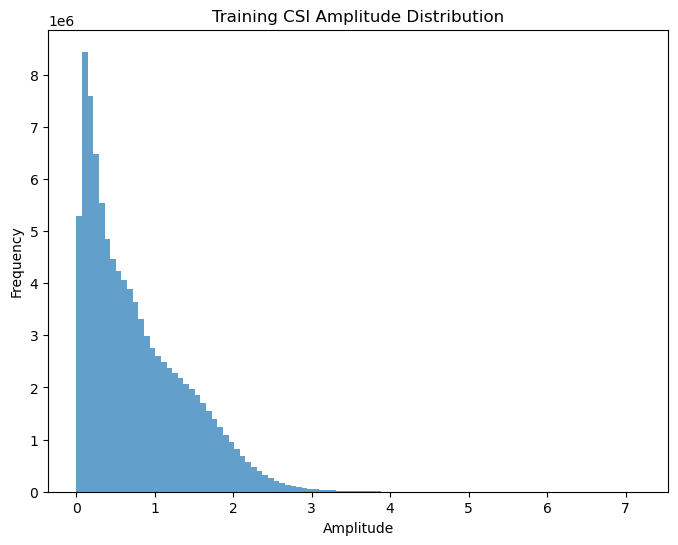

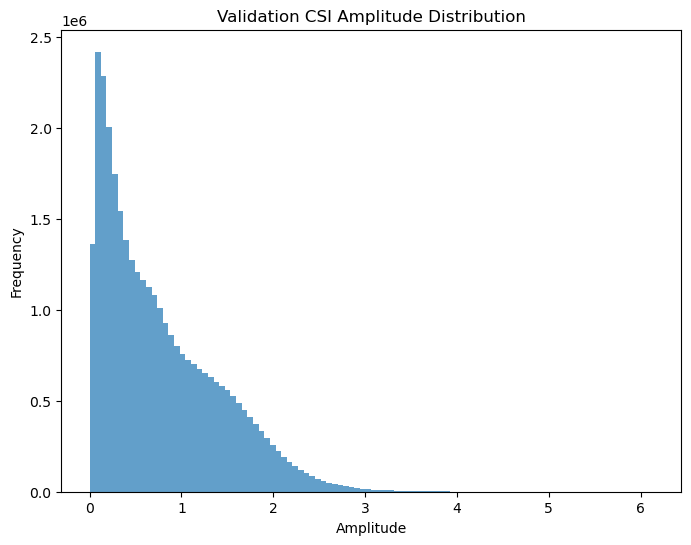

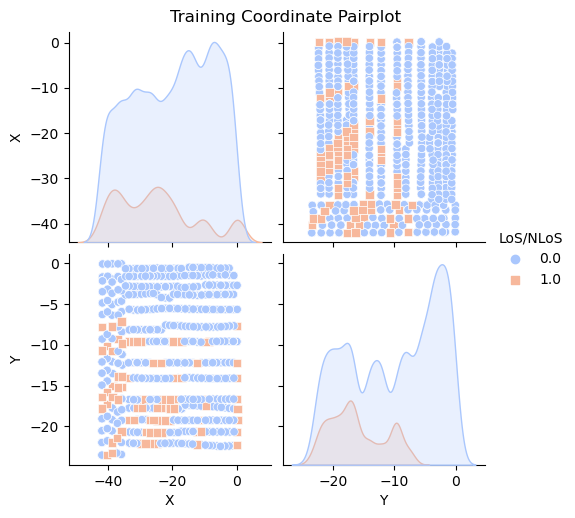

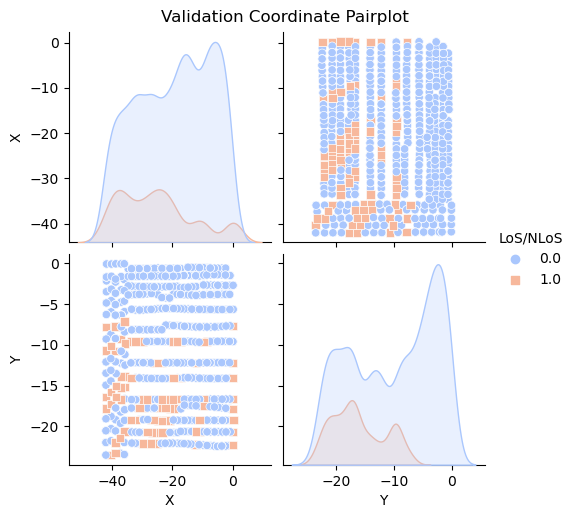

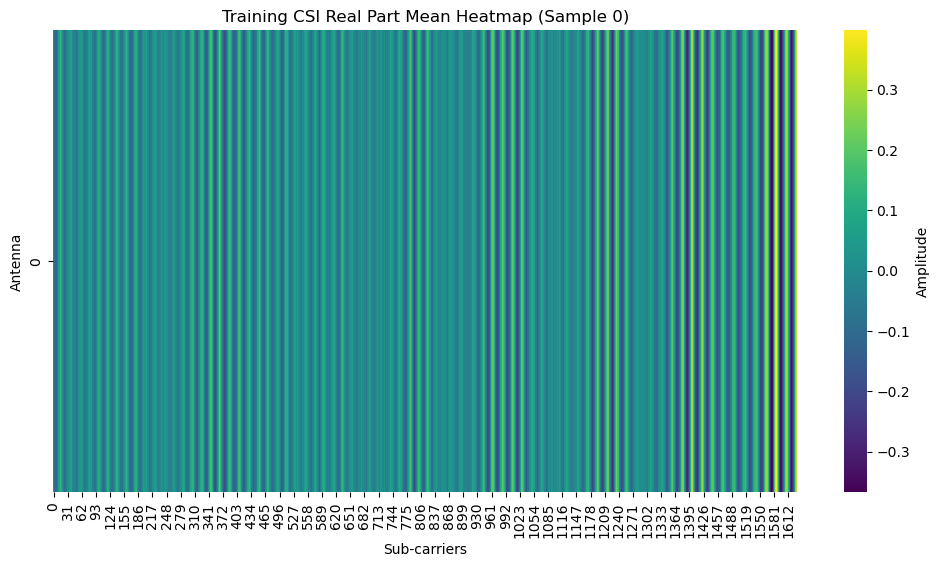

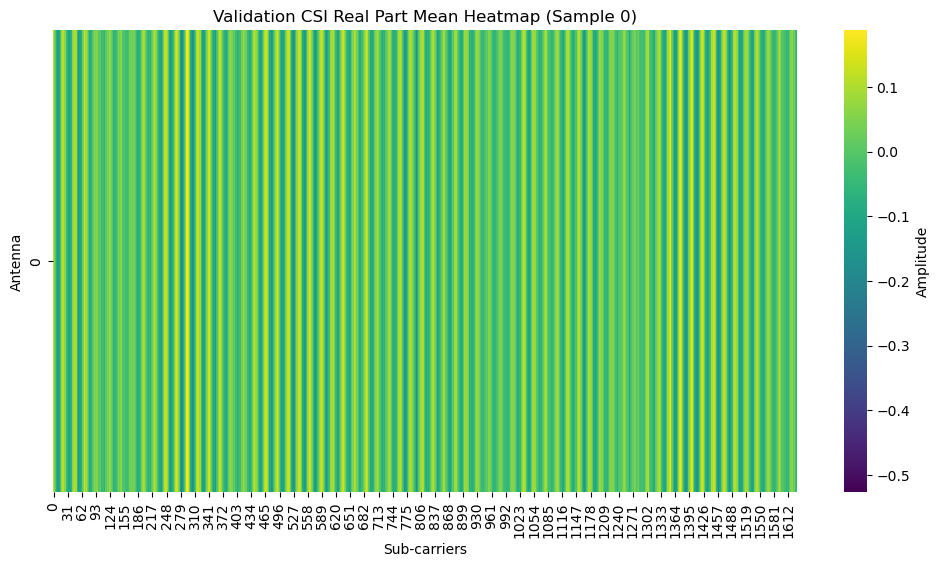

In [15]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

train_dl_origin = torch.load('train_dl.pt')
valid_dl_origin = torch.load('valid_dl.pt')

train_CSI = train_dl_origin.dataset[:][0]
train_labels = train_dl_origin.dataset[:][1]
valid_CSI = valid_dl_origin.dataset[:][0]
valid_labels = valid_dl_origin.dataset[:][1]

def normalize_csi(CSI):
    mean = CSI.mean(dim=(0, 1, 2), keepdim=True)
    std = CSI.std(dim=(0, 1, 2), keepdim=True)
    CSI_normalized = (CSI - mean) / std
    return CSI_normalized

train_CSI_normalized = normalize_csi(train_CSI)
valid_CSI_normalized = normalize_csi(valid_CSI)

def plot_csi_histogram(CSI, dataset_name):
    plt.figure(figsize=(8, 6))
    plt.hist(CSI.abs().flatten().numpy(), bins=100, alpha=0.7)
    plt.title(f'{dataset_name} CSI Amplitude Distribution')
    plt.xlabel('Amplitude')
    plt.ylabel('Frequency')
    plt.show()

plot_csi_histogram(train_CSI_normalized, "Training")
plot_csi_histogram(valid_CSI_normalized, "Validation")

# Pairplot of x, y coordinates for LoS and NLoS
def plot_coordinate_pairplot(labels, dataset_name):
    data = {
        'X': labels[:, 0].numpy(),
        'Y': labels[:, 1].numpy(),
        'LoS/NLoS': labels[:, 2].numpy()
    }
    df = pd.DataFrame(data)
    sns.pairplot(df, hue='LoS/NLoS', palette='coolwarm', markers=["o", "s"])
    plt.suptitle(f'{dataset_name} Coordinate Pairplot', y=1.02)
    plt.show()

plot_coordinate_pairplot(train_labels, "Training")
plot_coordinate_pairplot(valid_labels, "Validation")

def plot_csi_heatmap(CSI, dataset_name, sample_index=0):
    real_mean_values = CSI[sample_index, 0, :, :].real.mean(axis=0)
    plt.figure(figsize=(12, 6))
    sns.heatmap(real_mean_values.unsqueeze(0).numpy(), cmap='viridis', cbar_kws={'label': 'Amplitude'})
    plt.title(f'{dataset_name} CSI Real Part Mean Heatmap (Sample {sample_index})')
    plt.xlabel('Sub-carriers')
    plt.ylabel('Antenna')
    plt.show()

plot_csi_heatmap(train_CSI_normalized, "Training", sample_index=0)
plot_csi_heatmap(valid_CSI_normalized, "Validation", sample_index=0)

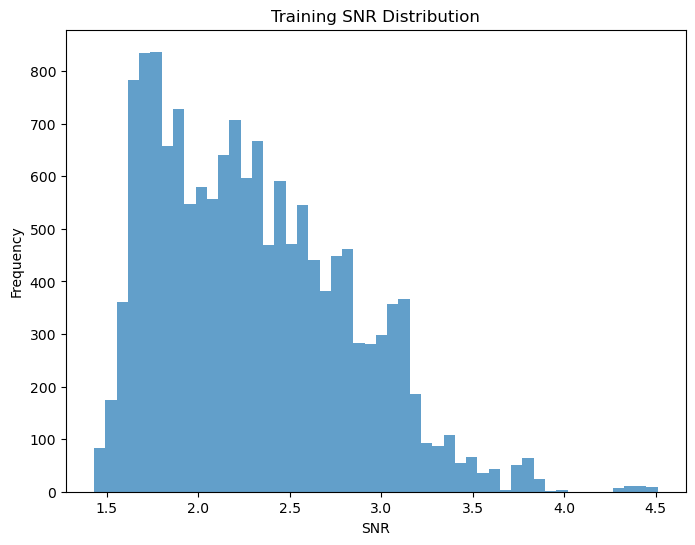

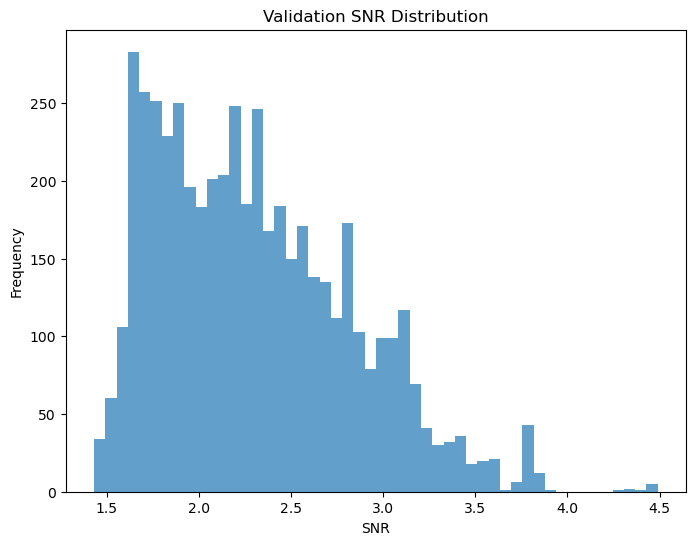

In [16]:
import matplotlib.pyplot as plt

def calculate_snr(CSI):
    snr = CSI.abs().mean(dim=(2, 3)) / CSI.abs().std(dim=(2, 3))
    return snr

train_snr = calculate_snr(train_CSI_normalized)
valid_snr = calculate_snr(valid_CSI_normalized)

def plot_snr_distribution(snr, dataset_name):
    plt.figure(figsize=(8, 6))
    plt.hist(snr.numpy(), bins=50, alpha=0.7)
    plt.title(f'{dataset_name} SNR Distribution')
    plt.xlabel('SNR')
    plt.ylabel('Frequency')
    plt.show()

plot_snr_distribution(train_snr, "Training")
plot_snr_distribution(valid_snr, "Validation")

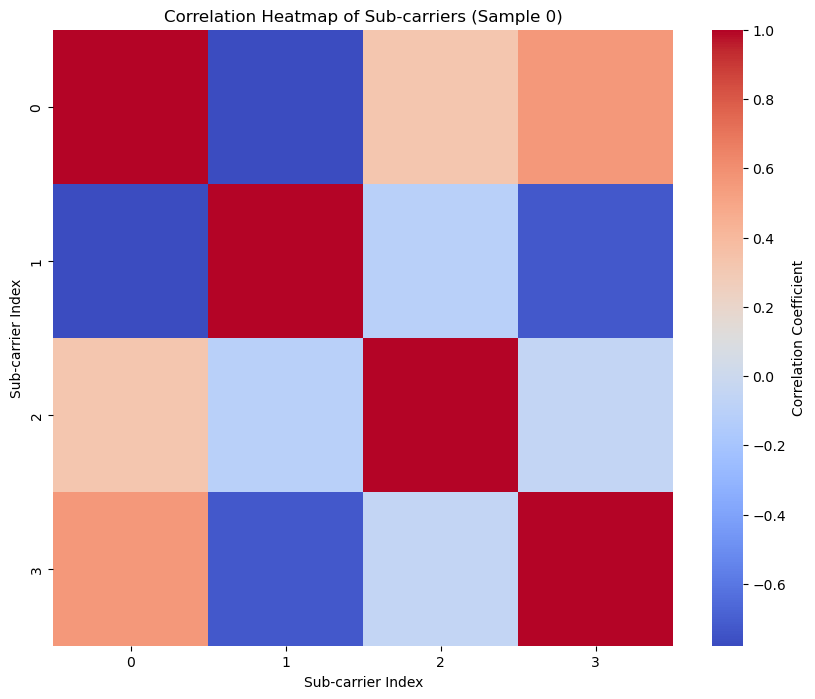

In [17]:
import numpy as np

# Calculate correlation matrix for the first sample
def calculate_correlation(CSI):
    flattened = CSI[0, 0].real.numpy().reshape(-1, 1632)
    correlation_matrix = np.corrcoef(flattened)
    return correlation_matrix

correlation_matrix = calculate_correlation(train_CSI_normalized)

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap of Sub-carriers (Sample 0)')
plt.xlabel('Sub-carrier Index')
plt.ylabel('Sub-carrier Index')
plt.show()

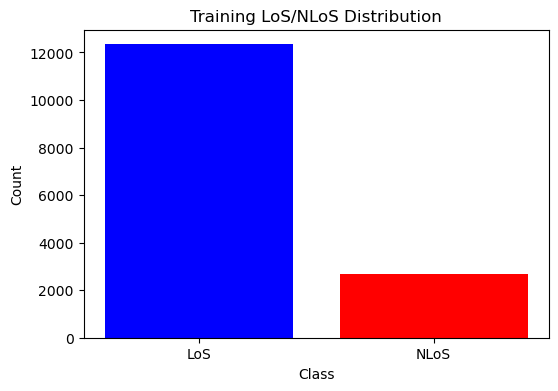

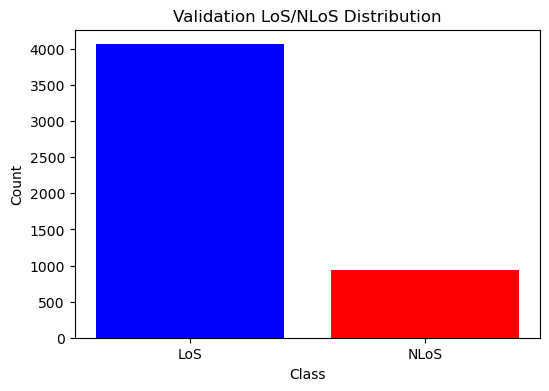

In [18]:
def plot_class_distribution(labels, dataset_name):
    los_count = (labels[:, 2] == 0).sum().item()
    nlos_count = (labels[:, 2] == 1).sum().item()
    plt.figure(figsize=(6, 4))
    plt.bar(['LoS', 'NLoS'], [los_count, nlos_count], color=['blue', 'red'])
    plt.title(f'{dataset_name} LoS/NLoS Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution(train_labels, "Training")
plot_class_distribution(valid_labels, "Validation")